In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# standard library
import re
from collections import Counter

# NLP library
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/real-and-fake-news/True.csv
/kaggle/input/real-and-fake-news/Fake.csv


In [2]:
fake = pd.read_csv("/kaggle/input/real-and-fake-news/Fake.csv")
true = pd.read_csv("/kaggle/input/real-and-fake-news/True.csv")

# Data Analysis

In [3]:
fake.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [4]:
true.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [5]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [6]:
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


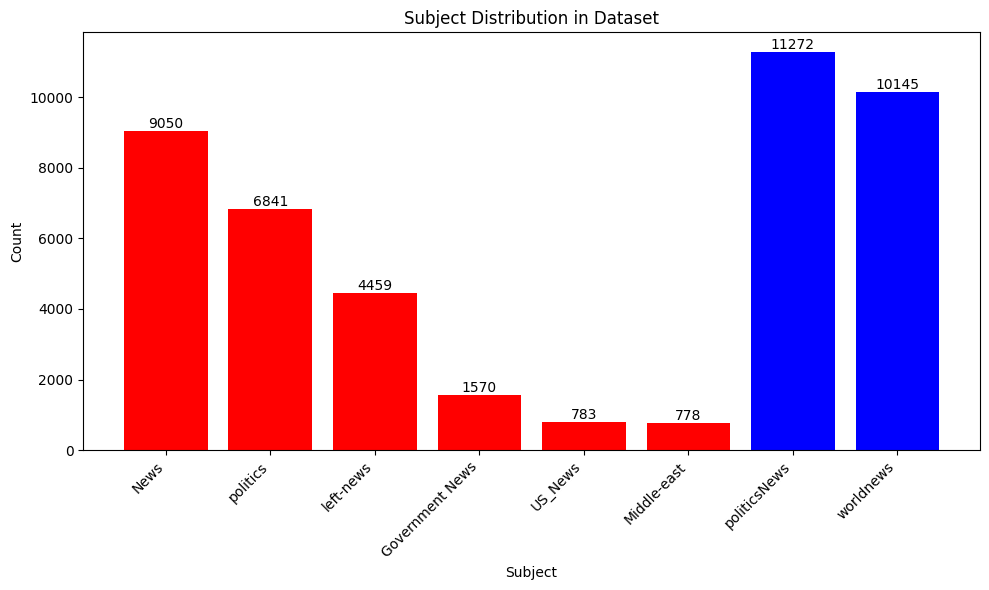

In [7]:
fake_counts = fake['subject'].value_counts()
true_counts = true['subject'].value_counts();

plt.figure(figsize=(10, 6))
bars = plt.bar(fake_counts.index, fake_counts.values, color='red')
bars += plt.bar(true_counts.index, true_counts.values, color='blue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
             ha='center', va='bottom', fontsize=10)

plt.title('Subject Distribution in Dataset')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
def count_words(titles):
    words = word_tokenize(titles.lower())
    words = [re.sub(r'[^a-z]', '', word) for word in words] # removes non-alphabetical characters
    words = [word for word in words if word and word not in stopwords.words('english')] # removes stopwords

    return Counter(words)

In [9]:
fake_titles = " ".join(fake['title'].tolist())
true_titles = " ".join(true['title'].tolist())

fake_count = count_words(fake_titles)
true_count = count_words(true_titles)
fake_common = fake_count.most_common(15)
true_common = true_count.most_common(15)
print("15 most common words in fake articles: ")
for word, count in fake_common:
    print(f"{word}: {count}")
print("15 most common words in true articles: ")
for word, count in true_common:
    print(f"{word}: {count}")

15 most common words in fake articles: 
trump: 8713
video: 8377
obama: 2487
hillary: 2199
watch: 1905
clinton: 1099
president: 1091
us: 1045
new: 895
breaking: 880
news: 862
black: 860
white: 846
donald: 843
gop: 794
15 most common words in true articles: 
trump: 5411
us: 4033
says: 2981
house: 1443
north: 925
russia: 914
korea: 881
new: 875
white: 815
china: 767
senate: 759
court: 723
bill: 686
clinton: 646
state: 645


# Data Preprocessing

In [10]:
true['label'] = 0
fake['label'] = 1

data = pd.concat([true[['label', 'title', 'text']], fake[['label', 'title', 'text']]])

In [11]:
data['article'] = data['title'] + " " + data['text']
data = data.drop(['title', 'text'], axis=1)
data = data.sample(frac=1, random_state=36).reset_index(drop=True)
data

,label,article
0,0,Ukraine's Poroshenko suggests IMF-backed anti-...
1,0,Republican Senator Hatch rejects bipartisan he...
2,1,The Republican Jewish Coalition Loves Trump S...
3,0,Cruz's Iowa victory could show Big Corn's wani...
4,0,"Britain's ""Madame Brexit"" tells Poland: Your c..."
...,...,...
44893,1,"BREAKING: Lawsuit Shows Trump Wanted To Fire,..."
44894,0,Hollande and Trump agreed to 'clarify' key iss...
44895,1,Stephen King Makes Trump His Newest Horror St...
44896,1,LOL! $45 MILLION DOLLAR WHOOPI Complains Conse...


In [12]:
def clean(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) # removes punctuation
    text = re.sub(r'\s+', ' ', text) # sets all spaces to be single-spaced

    # removes stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    text = ' '.join([word for word in tokens if word not in stop_words])
    
    return text

In [13]:
data['article'] = data['article'].apply(clean)
data

,label,article
0,0,ukraines poroshenko suggests imfbacked antigra...
1,0,republican senator hatch rejects bipartisan he...
2,1,republican jewish coalition loves trump much f...
3,0,cruzs iowa victory could show big corns waning...
4,0,britains madame brexit tells poland constituti...
...,...,...
44893,1,breaking lawsuit shows trump wanted fire repla...
44894,0,hollande trump agreed clarify key issues inclu...
44895,1,stephen king makes trump newest horror story f...
44896,1,lol 45 million dollar whoopi complains conserv...


# Building Model

In [14]:
vectorizer = TfidfVectorizer(max_features=7000)

X = vectorizer.fit_transform(data['article'])
y = data['label']
print(X.shape)

(44898, 7000)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

In [16]:
model = LinearSVC(random_state=36)

model.fit(X_train, y_train)

LinearSVC(random_state=36)

In [17]:
y_pred = model.predict(X_test)

# Evaluation

In [18]:
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

Evaluation Metrics:
Accuracy: 0.9965478841870824
Precision: 0.9970117395944503
Recall: 0.9963737201365188
F1 Score: 0.9966926277605889


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4292
           1       1.00      1.00      1.00      4688

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



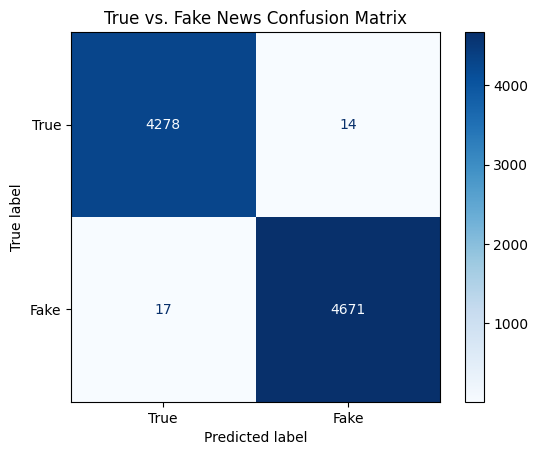

In [20]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=["True", "Fake"])
disp.plot(cmap="Blues")
plt.title("True vs. Fake News Confusion Matrix")
plt.show()